# Content
* [1. Renrendai loans](#1)
   * [1.1 Data Summary](#1.1)
   * [1.2 Feature cleanning and engenering](#1.2)
       * [1.2.1 On Default regression](#1.2.1)
       * [1.2.2 On Bids regression](#1.2.2)
   * [1.3 Logit regression](#1.3)
   * [1.4 Ols Regression](#1.4)
* [2. P2P lending platform](#2)
   * [2.1 Datasummary](#2.1)
   * [2.2 Cox Model](#2.2)

<a id="1"></a>
## 1.Renrendai loans

<a id="1.1"></a>
##  1.1 Data Summary

In this part we overlook all the data in "Renrendai".   
(1) We found there are total 10k records X 25 features.  
Most of the features contained clean data except serval features contain incomplete data  
 (
    EDUCATION    9996 non-null   float64  
    WORKTIME     9994 non-null   float64  
    INCOME       9998 non-null   float64  
    IND          9318 non-null   object  
    CITY         9857 non-null   object   
    PURPOSE  9994 non -null       object
 )  
 
 (2) There are 10 features are objects including: STATUS, IND-Industry, City, Purpose, Marry, Open time, Readytime, Title  
 Description, nickname  
 2.1) I transform time value from time to integer for further study,only keeping duration(Ready time -Open time)
 2.2) Create dummy variables for Lable feature with few types including: Marry, Purpose, IND

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
data = pd.read_csv(r"..\Week 2 Assignment\loanraw.csv",encoding="gbk")
data.head()

,loanId,STATUS,BIDS,DEFAULT,AMOUNT,INTEREST,MONTHS,CREDIT,HOUSE,CAR,...,IND,CITY,PURPOSE,MARRY,AGE,opentime,readytime,title,description,nickName
0,2,CLOSED,9,0,3000,5.0,6,7,1,1,...,IT,北京,其他借款,未婚,33,2010/10/12 17:17,2010/10/15 11:00,庆祝上线,"看着人人贷经过精心的筹备,和长时间的内测,终于正式和大家见面了.特地来发个标, 希望大家多多...",一夫
1,11,CLOSED,8,0,3000,18.0,3,3,0,0,...,教育/培训,北京,其他借款,未婚,37,2010/10/18 16:40,2010/10/21 17:07,增加信用，重新发布借款,第一次借款不幸失败，这次特意做了收入审核。希望之前支持的朋友继续支持我，新朋友也可以看看我做...,郭遐
2,16,CLOSED,8,0,3000,12.0,12,3,0,0,...,教育/培训,北京,其他借款,未婚,37,2010/10/21 17:26,2010/10/28 14:35,积累信用，继续发标,做过收入认证果然不一样，第一次发标失败了，第二次做了收入认证很快就满标了。 这次降低一点利率...,郭遐
3,19,CLOSED,11,0,3000,8.8,12,7,1,1,...,IT,北京,其他借款,未婚,33,2010/10/25 17:19,2010/10/28 20:58,信用与人人贷一起进步,刚才提前还清了第一笔借款，以证明自己的信用。再次发标只为继续积累信用和人气。希望朋友们投标。...,一夫
4,20,CLOSED,15,0,5000,15.0,12,7,0,1,...,其它,北京,个人消费,未婚,33,2010/10/26 14:29,2010/10/28 14:34,刚刚搬出来自己住，借钱添置些东西,工作也有两年多了，打算自己搬出来住了. 房子已经租好了，跟一个朋友合住，我一个月出1200....,小猫Mia


In [4]:
data.shape

(10000, 25)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   loanId       10000 non-null  int64  
 1   STATUS       10000 non-null  object 
 2   BIDS         10000 non-null  int64  
 3   DEFAULT      10000 non-null  int64  
 4   AMOUNT       10000 non-null  int64  
 5   INTEREST     10000 non-null  float64
 6   MONTHS       10000 non-null  int64  
 7   CREDIT       10000 non-null  int64  
 8   HOUSE        10000 non-null  int64  
 9   CAR          10000 non-null  int64  
 10  HOUSE_L      10000 non-null  int64  
 11  CAR_L        10000 non-null  int64  
 12  EDUCATION    9996 non-null   float64
 13  WORKTIME     9994 non-null   float64
 14  INCOME       9998 non-null   float64
 15  IND          9318 non-null   object 
 16  CITY         9857 non-null   object 
 17  PURPOSE      9994 non-null   object 
 18  MARRY        10000 non-null  object 
 19  AGE  

### Construct new feature "duration" 
based on the gap between "readytime" and "opentime" (accurate to hour), using day as unit

In [6]:
data['duration'] = (pd.to_datetime(data["readytime"]) - pd.to_datetime(data["opentime"])).astype('timedelta64[h]').astype(float)/24
data.describe()['duration']

count    10000.000000
mean         3.769125
std          4.548706
min         -0.500000
25%          0.000000
50%          2.625000
75%          5.708333
max         37.375000
Name: duration, dtype: float64

### Construct new dummy variables for label features 
MARRY: 4 possible status
PURPOSE: 10 possible status
IND : 20 possible status

In [7]:
data_2 = pd.get_dummies(data,columns=["MARRY","PURPOSE","IND"])

In [8]:
data_2.columns

Index(['loanId', 'STATUS', 'BIDS', 'DEFAULT', 'AMOUNT', 'INTEREST', 'MONTHS',
       'CREDIT', 'HOUSE', 'CAR', 'HOUSE_L', 'CAR_L', 'EDUCATION', 'WORKTIME',
       'INCOME', 'CITY', 'AGE', 'opentime', 'readytime', 'title',
       'description', 'nickName', 'duration', 'MARRY_丧偶', 'MARRY_已婚',
       'MARRY_未婚', 'MARRY_离异', 'PURPOSE_个人消费', 'PURPOSE_其他借款', 'PURPOSE_医疗支出',
       'PURPOSE_婚礼筹备', 'PURPOSE_投资创业', 'PURPOSE_教育培训', 'PURPOSE_短期周转',
       'PURPOSE_装修借款', 'PURPOSE_购房借款', 'PURPOSE_购车借款', 'IND_IT', 'IND_交通运输业',
       'IND_体育/艺术', 'IND_公共事业', 'IND_公益组织', 'IND_其它', 'IND_农业', 'IND_制造业',
       'IND_医疗/卫生/保健', 'IND_娱乐服务业', 'IND_媒体/广告', 'IND_建筑工程', 'IND_房地产业',
       'IND_政府机关', 'IND_教育/培训', 'IND_能源业', 'IND_计算机系统', 'IND_金融/法律',
       'IND_零售/批发', 'IND_餐饮/旅馆业'],
      dtype='object')

### Data summary based on experience
Bowrrer characteristics: Credit, car, house, education, worktime, Income   
Loan characteristics: Amount, interest,MONTHS, duration

In [9]:
data_2.describe()[["CREDIT","CAR","HOUSE","EDUCATION","INCOME","WORKTIME"]]

,CREDIT,CAR,HOUSE,EDUCATION,INCOME,WORKTIME
count,10000.00000,10000.000000,10000.000000,9996.000000,9998.000000,9994.000000
mean,2.14630,0.391700,0.564500,2.165966,4.309162,2.838003
std,1.53099,0.488155,0.495847,0.818108,1.335842,0.992755
min,1.00000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,1.00000,0.000000,0.000000,2.000000,3.000000,2.000000
50%,2.00000,0.000000,1.000000,2.000000,4.000000,3.000000
75%,3.00000,1.000000,1.000000,3.000000,5.000000,4.000000
max,7.00000,1.000000,1.000000,4.000000,7.000000,4.000000


In [10]:
data_2.describe()[["AMOUNT","INTEREST","MONTHS","duration"]]

,AMOUNT,INTEREST,MONTHS,duration
count,10000.000000,10000.000000,10000.00000,10000.000000
mean,24545.835000,12.621900,12.23730,3.769125
std,38280.756524,2.273689,8.09109,4.548706
min,3000.000000,5.000000,3.00000,-0.500000
25%,8000.000000,11.000000,6.00000,0.000000
50%,14400.000000,12.000000,12.00000,2.625000
75%,26000.000000,13.000000,12.00000,5.708333
max,500000.000000,24.400000,36.00000,37.375000


<a id="1.2"></a>
## 1.2 Feature cleaning and engineering
1. Key Variables for Default regression
2. Key variables for Bids regression

<a id="1.2.1"></a>
### 1.2.1 On Default regression
(1) Based on the result, I just take the four features ahead of loanId.  
(EDUCATION feature needs to be clean up: Because the number of missing records is small and variance is small and it belongs to discrete feature. I simply use median to fill the null value)  

There are no missing records in BIDS

In [11]:
data_2["DEFAULT"].value_counts()

0    8487
1    1513
Name: DEFAULT, dtype: int64

### Correlatin test
Based on the result, I pick 

In [12]:
abs(data_2.corr()["DEFAULT"]).sort_values(ascending=False)[0:41]

DEFAULT         1.000000
CREDIT          0.292815
MONTHS          0.274555
EDUCATION       0.154944
CAR             0.095841
loanId          0.094200
INTEREST        0.082417
MARRY_离异        0.080191
PURPOSE_装修借款    0.072103
HOUSE_L         0.070177
PURPOSE_购车借款    0.059450
PURPOSE_短期周转    0.054436
IND_IT          0.053042
duration        0.047243
PURPOSE_个人消费    0.044998
HOUSE           0.036634
IND_交通运输业       0.033180
IND_零售/批发       0.032275
AGE             0.026891
PURPOSE_投资创业    0.026225
IND_金融/法律       0.026032
CAR_L           0.024758
WORKTIME        0.023593
IND_制造业         0.022934
IND_农业          0.020576
PURPOSE_教育培训    0.020135
PURPOSE_其他借款    0.020104
IND_政府机关        0.018748
MARRY_未婚        0.017888
IND_能源业         0.016393
BIDS            0.015241
IND_其它          0.014405
IND_体育/艺术       0.014041
IND_建筑工程        0.013458
MARRY_已婚        0.013389
IND_教育/培训       0.011902
IND_餐饮/旅馆业      0.010136
IND_医疗/卫生/保健    0.009476
PURPOSE_购房借款    0.009074
IND_公益组织        0.007794


In [82]:
abs(data_2.corr()["DEFAULT"]).sort_values(ascending=False)[0:11]
index = abs(data_2.corr()["DEFAULT"]).sort_values(ascending=False)[1:11].index

DEFAULT         1.000000
CREDIT          0.292815
MONTHS          0.274555
EDUCATION       0.154903
CAR             0.095841
loanId          0.094200
INTEREST        0.082417
MARRY_离异        0.080191
PURPOSE_装修借款    0.072103
HOUSE_L         0.070177
PURPOSE_购车借款    0.059450
Name: DEFAULT, dtype: float64

#### Heatmap for rank 10 features

<AxesSubplot:>

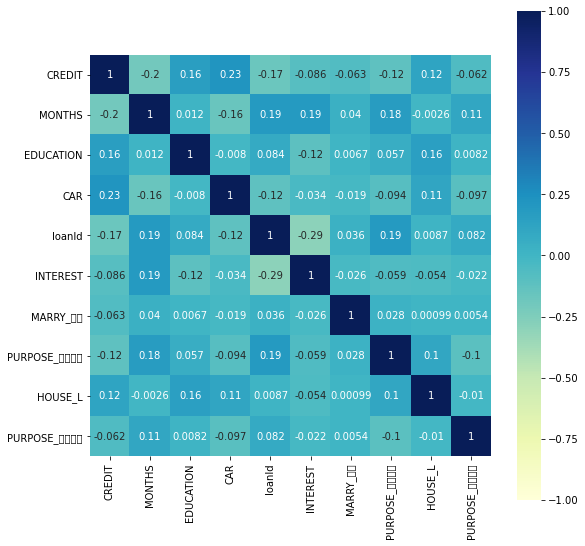

In [84]:
fig, ax = plt.subplots(figsize = (9,9))
sns.heatmap(data_2[index].corr(),annot=True, vmax=1, vmin=-1,square=True,cmap="YlGnBu")

#### Heatmap for rank 4 features (features beat loan id)

<AxesSubplot:>

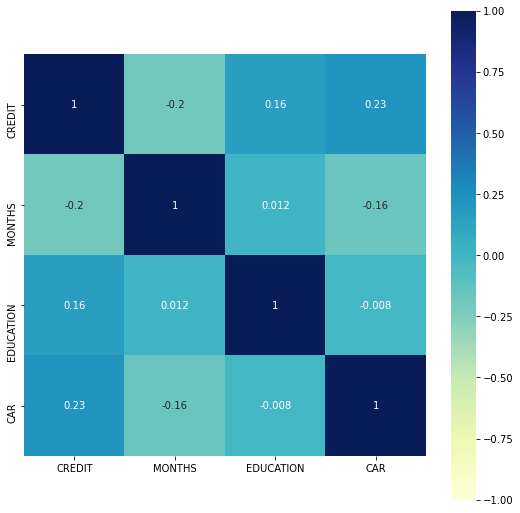

In [15]:
fig, ax = plt.subplots(figsize = (9,9))
sns.heatmap(data_2[["CREDIT","MONTHS","EDUCATION","CAR"]].corr(),annot=True, vmax=1, vmin=-1,square=True,cmap="YlGnBu")

In [16]:
data_2.describe()[["CREDIT","MONTHS","EDUCATION","CAR"]]

,CREDIT,MONTHS,EDUCATION,CAR
count,10000.00000,10000.00000,9996.000000,10000.000000
mean,2.14630,12.23730,2.165966,0.391700
std,1.53099,8.09109,0.818108,0.488155
min,1.00000,3.00000,1.000000,0.000000
25%,1.00000,6.00000,2.000000,0.000000
50%,2.00000,12.00000,2.000000,0.000000
75%,3.00000,12.00000,3.000000,1.000000
max,7.00000,36.00000,4.000000,1.000000


#### Filling null value in EDUCATION feature 

In [17]:
data_2["EDUCATION"][data_2["EDUCATION"].isnull()] = data_2["EDUCATION"].median()

<ipython-input-17-2bafad20e43f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2["EDUCATION"][data_2["EDUCATION"].isnull()] = data_2["EDUCATION"].median()


In [18]:
data_2.describe()[["CREDIT","MONTHS","EDUCATION","CAR"]]

,CREDIT,MONTHS,EDUCATION,CAR
count,10000.00000,10000.00000,10000.000000,10000.000000
mean,2.14630,12.23730,2.165900,0.391700
std,1.53099,8.09109,0.817951,0.488155
min,1.00000,3.00000,1.000000,0.000000
25%,1.00000,6.00000,2.000000,0.000000
50%,2.00000,12.00000,2.000000,0.000000
75%,3.00000,12.00000,3.000000,1.000000
max,7.00000,36.00000,4.000000,1.000000


<a id="1.2.2"></a>
### 1.2.2 On Bids regression
1.Based on the correlation test result, I found there are far more features are highly relevant to BIDS  
I select features ranking high from highest AMOUNT to INTEREST  
There are few missing records in INCOME and WORKTIME. Similar to CAR, I simply use median value to fill the records.

There are no missing records in BIDS

In [19]:
data_2.describe()['BIDS']

count    10000.000000
mean        24.150600
std         41.342608
min          1.000000
25%          9.000000
50%         15.000000
75%         24.000000
max        592.000000
Name: BIDS, dtype: float64

In [20]:
abs(data_2.corr()["BIDS"]).sort_values(ascending=False)[1:13]
bidsIndex_0 = abs(data_2.corr()["BIDS"]).sort_values(ascending=False)[1:13].index

AMOUNT          0.809234
INCOME          0.357055
AGE             0.257725
IND_制造业         0.188173
CAR             0.183072
loanId          0.159011
WORKTIME        0.139645
CREDIT          0.122454
MARRY_已婚        0.122299
MARRY_未婚        0.117044
PURPOSE_其他借款    0.105537
INTEREST        0.097306
Name: BIDS, dtype: float64

#### According to the heatmap
I found two status of marriage is highly related, So I drop the dismarriaged feature

C:\Users\Administrator\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 21046 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Administrator\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 36896 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Administrator\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 19994 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Administrator\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Administrator\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 23130 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Administrator\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py

<AxesSubplot:>

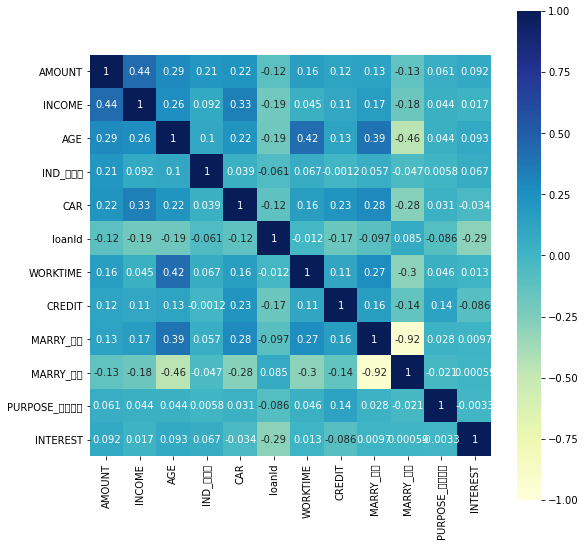

In [21]:
fig, ax = plt.subplots(figsize = (9,9))
sns.heatmap(data_2[bidsIndex_0].corr(),annot=True, vmax=1, vmin=-1,square=True,cmap="YlGnBu")

In [22]:
bidsIndex_0 = bidsIndex_0.drop("MARRY_未婚")
bidsIndex_0

Index(['AMOUNT', 'INCOME', 'AGE', 'IND_制造业', 'CAR', 'loanId', 'WORKTIME',
       'CREDIT', 'MARRY_已婚', 'PURPOSE_其他借款', 'INTEREST'],
      dtype='object')

In [23]:
data_2.describe()[bidsIndex_0]

,AMOUNT,INCOME,AGE,IND_制造业,CAR,loanId,WORKTIME,CREDIT,MARRY_已婚,PURPOSE_其他借款,INTEREST
count,10000.000000,9998.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,9994.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,24545.835000,4.309162,34.755500,0.199700,0.391700,4.188469e+05,2.838003,2.14630,0.638500,0.047100,12.621900
std,38280.756524,1.335842,6.682708,0.399795,0.488155,4.464326e+05,0.992755,1.53099,0.480459,0.211863,2.273689
min,3000.000000,1.000000,24.000000,0.000000,0.000000,2.000000e+00,1.000000,1.00000,0.000000,0.000000,5.000000
25%,8000.000000,3.000000,30.000000,0.000000,0.000000,8.463525e+04,2.000000,1.00000,0.000000,0.000000,11.000000
50%,14400.000000,4.000000,33.000000,0.000000,0.000000,3.219450e+05,3.000000,2.00000,1.000000,0.000000,12.000000
75%,26000.000000,5.000000,38.000000,0.000000,1.000000,5.829305e+05,4.000000,3.00000,1.000000,0.000000,13.000000
max,500000.000000,7.000000,53.000000,1.000000,1.000000,2.086049e+06,4.000000,7.00000,1.000000,1.000000,24.400000


#### Filling missing records for INCOME and WORKTIME

In [26]:
data_2["INCOME"][data_2["INCOME"].isnull()] = data_2["INCOME"].median()
data_2["WORKTIME"][data_2["WORKTIME"].isnull()] = data_2["WORKTIME"].median()
data_2.describe()[bidsIndex_0]

<ipython-input-26-7b60960dbc47>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2["INCOME"][data_2["INCOME"].isnull()] = data_2["INCOME"].median()
<ipython-input-26-7b60960dbc47>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2["WORKTIME"][data_2["WORKTIME"].isnull()] = data_2["WORKTIME"].median()


,AMOUNT,INCOME,AGE,IND_制造业,CAR,loanId,WORKTIME,CREDIT,MARRY_已婚,PURPOSE_其他借款,INTEREST
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,24545.835000,4.309100,34.755500,0.199700,0.391700,4.188469e+05,2.838100,2.14630,0.638500,0.047100,12.621900
std,38280.756524,1.335715,6.682708,0.399795,0.488155,4.464326e+05,0.992465,1.53099,0.480459,0.211863,2.273689
min,3000.000000,1.000000,24.000000,0.000000,0.000000,2.000000e+00,1.000000,1.00000,0.000000,0.000000,5.000000
25%,8000.000000,3.000000,30.000000,0.000000,0.000000,8.463525e+04,2.000000,1.00000,0.000000,0.000000,11.000000
50%,14400.000000,4.000000,33.000000,0.000000,0.000000,3.219450e+05,3.000000,2.00000,1.000000,0.000000,12.000000
75%,26000.000000,5.000000,38.000000,0.000000,1.000000,5.829305e+05,4.000000,3.00000,1.000000,0.000000,13.000000
max,500000.000000,7.000000,53.000000,1.000000,1.000000,2.086049e+06,4.000000,7.00000,1.000000,1.000000,24.400000


#### To illustrate the relationship better we plot the figure
Relationship between BIDS and threee most significant features

Cutting data 

In [27]:
data_2.loc[:,"AMOUNTLABEL"] = pd.cut(data["AMOUNT"],5)
data_2.loc[:,"AGELABEL"] = pd.cut(data["AGE"],3)

In [28]:
data_2["AMOUNTLABEL"].value_counts()
data_2["AGELABEL"].value_counts()

(2503.0, 102400.0]      9732
(102400.0, 201800.0]     186
(201800.0, 301200.0]      63
(400600.0, 500000.0]      11
(301200.0, 400600.0]       8
Name: AMOUNTLABEL, dtype: int64

(23.971, 33.667]    5053
(33.667, 43.333]    3702
(43.333, 53.0]      1245
Name: AGELABEL, dtype: int64

In [29]:
amountLabels = []
for label in data_2["AMOUNTLABEL"].value_counts().index:
    amountLabels.append(str(label))

incomeLabels = [1,2,3,4,5,6,7]
ageLabels = ["23-33","33-43","43-53"]


<Figure size 1008x576 with 0 Axes>

<AxesSubplot:>

Text(0.5, 0, 'AMOUNT')

Text(0, 0.5, 'BIDS')

<AxesSubplot:>

Text(0.5, 0, 'INCOME')

<AxesSubplot:>

Text(0.5, 0, 'AGE')

<function matplotlib.pyplot.show(close=None, block=None)>

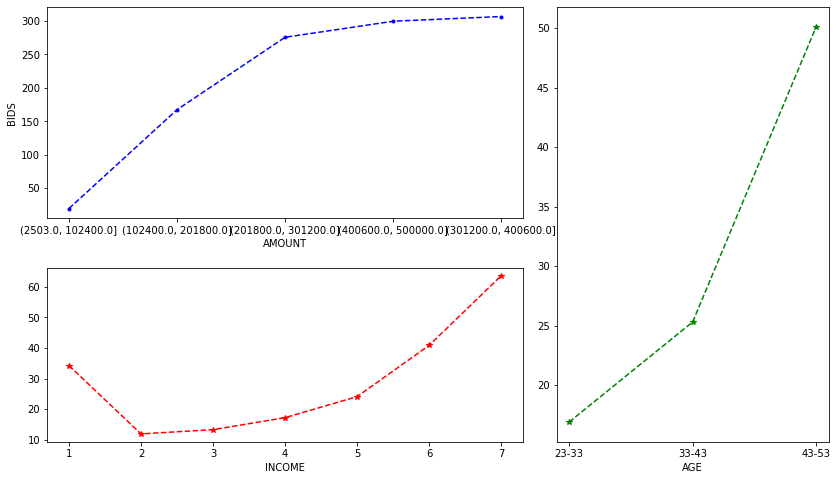

In [80]:
plt.figure(figsize=[14, 8])
grid = plt.GridSpec(12, 8, wspace=0.5, hspace=0.5)
plt.subplot(grid[0:6,0:5])

plt.plot(amountLabels,data_2.groupby(["AMOUNTLABEL"])["BIDS"].mean(),"b--.")

plt.xlabel("AMOUNT")
plt.ylabel("BIDS")

plt.subplot(grid[7:12,0:5])

plt.plot(incomeLabels,data_2.groupby(["INCOME"])["BIDS"].mean(),"r--*")
plt.xlabel("INCOME")


plt.subplot(grid[0:12,5:8])

plt.plot(ageLabels,data_2.groupby(["AGELABEL"])["BIDS"].mean(),"g--*")
plt.xlabel("AGE")
plt.show

<a id="1.3"></a>
### 1.3 Logit Regression

In [31]:
data_2["intercept"] = 1.0

In [32]:
cols = []
for x in index: cols.append(str(x))
cols.append("intercept")
cols

['CREDIT',
 'MONTHS',
 'EDUCATION',
 'CAR',
 'loanId',
 'INTEREST',
 'MARRY_离异',
 'PURPOSE_装修借款',
 'HOUSE_L',
 'PURPOSE_购车借款',
 'intercept']

In [33]:
model = sm.Logit(data_2['DEFAULT'],data_2[cols])
result1 = model.fit()
result1.summary()

Optimization terminated successfully.
         Current function value: 0.300684
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                DEFAULT   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9989
Method:                           MLE   Df Model:                           10
Date:                Fri, 24 Sep 2021   Pseudo R-squ.:                  0.2924
Time:                        20:32:04   Log-Likelihood:                -3006.8
converged:                       True   LL-Null:                       -4249.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
CREDIT          -1.9959      0.088    -22.628      0.000      -2.169      -1.823
MONTHS           0.0739      0.004     19.270      0.000       0.066       0.081
EDUCATION       -0.5459      0.043    -12.640      0.000      -0.631      -0.461
CAR              0.0388      0.072      0.538      0.591      -0.103       0.180
loanId        8.013e-07   7.72e-08     10.377      0.000     6.5e-07    9.53e-07
INTEREST         0.0645      0.016      3.974      0.000       0.033       0.096
MARRY_离异         0.8014      0.141      5.671      0.000       0.524       1.078
PURPOSE_装修借款     0.1959      0.082      2.404      0.016       0.036       0.356
HOUSE_L         -0.3119      0.088     -3.560      0.000      -0.484      -0.140
PURPOSE_购车借款     0.2600      0.134      1.935      0.053      -0.003       0.523
intercept       -0.1468      0.261     -0.563      0.573      -0.657       0.364
================================================================================
"""

In [34]:
cols.pop(3)
cols

'CAR'

['CREDIT',
 'MONTHS',
 'EDUCATION',
 'loanId',
 'INTEREST',
 'MARRY_离异',
 'PURPOSE_装修借款',
 'HOUSE_L',
 'PURPOSE_购车借款',
 'intercept']

In [35]:

model = sm.Logit(data_2['DEFAULT'],data_2[cols])
result2 = model.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.300698
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                DEFAULT   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9990
Method:                           MLE   Df Model:                            9
Date:                Fri, 24 Sep 2021   Pseudo R-squ.:                  0.2924
Time:                        20:32:04   Log-Likelihood:                -3007.0
converged:                       True   LL-Null:                       -4249.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
CREDIT          -1.9934      0.088    -22.635      0.000      -2.166      -1.821
MONTHS           0.0737      0.004     19.300      0.000       0.066       0.081
EDUCATION       -0.5457      0.043    -12.636      0.000      -0.630      -0.461
loanId        7.994e-07   7.71e-08     10.362      0.000    6.48e-07    9.51e-07
INTEREST         0.0641      0.016      3.956      0.000       0.032       0.096
MARRY_离异         0.8016      0.141      5.672      0.000       0.525       1.079
PURPOSE_装修借款     0.1926      0.081      2.370      0.018       0.033       0.352
HOUSE_L         -0.3059      0.087     -3.521      0.000      -0.476      -0.136
PURPOSE_购车借款     0.2533      0.134      1.893      0.058      -0.009       0.516
intercept       -0.1299      0.259     -0.502      0.616      -0.637       0.377
================================================================================
"""

In [36]:
cols.pop(8)
cols

'PURPOSE_购车借款'

['CREDIT',
 'MONTHS',
 'EDUCATION',
 'loanId',
 'INTEREST',
 'MARRY_离异',
 'PURPOSE_装修借款',
 'HOUSE_L',
 'intercept']

In [37]:

model = sm.Logit(data_2['DEFAULT'],data_2[cols])
result3 = model.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.300875
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                DEFAULT   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9991
Method:                           MLE   Df Model:                            8
Date:                Fri, 24 Sep 2021   Pseudo R-squ.:                  0.2920
Time:                        20:32:04   Log-Likelihood:                -3008.7
converged:                       True   LL-Null:                       -4249.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
CREDIT          -1.9960      0.088    -22.657      0.000      -2.169      -1.823
MONTHS           0.0747      0.004     19.715      0.000       0.067       0.082
EDUCATION       -0.5454      0.043    -12.634      0.000      -0.630      -0.461
loanId        8.041e-07   7.71e-08     10.429      0.000    6.53e-07    9.55e-07
INTEREST         0.0630      0.016      3.893      0.000       0.031       0.095
MARRY_离异         0.8019      0.141      5.678      0.000       0.525       1.079
PURPOSE_装修借款     0.1684      0.080      2.098      0.036       0.011       0.326
HOUSE_L         -0.3068      0.087     -3.530      0.000      -0.477      -0.136
intercept       -0.1093      0.258     -0.423      0.672      -0.616       0.397
================================================================================
"""

In [38]:
cols.pop(3)
cols

'loanId'

['CREDIT',
 'MONTHS',
 'EDUCATION',
 'INTEREST',
 'MARRY_离异',
 'PURPOSE_装修借款',
 'HOUSE_L',
 'intercept']

In [39]:

model = sm.Logit(data_2['DEFAULT'],data_2[cols])
result4 = model.fit()
result4.summary()

Optimization terminated successfully.
         Current function value: 0.306135
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                DEFAULT   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9992
Method:                           MLE   Df Model:                            7
Date:                Fri, 24 Sep 2021   Pseudo R-squ.:                  0.2796
Time:                        20:32:04   Log-Likelihood:                -3061.4
converged:                       True   LL-Null:                       -4249.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
CREDIT          -1.8746      0.084    -22.218      0.000      -2.040      -1.709
MONTHS           0.0789      0.004     21.000      0.000       0.072       0.086
EDUCATION       -0.5103      0.042    -12.042      0.000      -0.593      -0.427
INTEREST         0.0099      0.016      0.639      0.523      -0.021       0.040
MARRY_离异         0.8011      0.140      5.708      0.000       0.526       1.076
PURPOSE_装修借款     0.2557      0.079      3.223      0.001       0.100       0.411
HOUSE_L         -0.3273      0.086     -3.788      0.000      -0.497      -0.158
intercept        0.6634      0.248      2.680      0.007       0.178       1.149
================================================================================
"""

In [40]:
cols.pop(3)
cols

'INTEREST'

['CREDIT',
 'MONTHS',
 'EDUCATION',
 'MARRY_离异',
 'PURPOSE_装修借款',
 'HOUSE_L',
 'intercept']

In [41]:
model = sm.Logit(data_2['DEFAULT'],data_2[cols])
result5 = model.fit()
result5.summary()

Optimization terminated successfully.
         Current function value: 0.306155
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                DEFAULT   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9993
Method:                           MLE   Df Model:                            6
Date:                Fri, 24 Sep 2021   Pseudo R-squ.:                  0.2796
Time:                        20:32:04   Log-Likelihood:                -3061.6
converged:                       True   LL-Null:                       -4249.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
CREDIT          -1.8790      0.084    -22.319      0.000      -2.044      -1.714
MONTHS           0.0793      0.004     21.346      0.000       0.072       0.087
EDUCATION       -0.5124      0.042    -12.123      0.000      -0.595      -0.430
MARRY_离异         0.7979      0.140      5.691      0.000       0.523       1.073
PURPOSE_装修借款     0.2514      0.079      3.182      0.001       0.097       0.406
HOUSE_L         -0.3275      0.086     -3.791      0.000      -0.497      -0.158
intercept        0.7967      0.133      5.981      0.000       0.536       1.058
================================================================================
"""

In [42]:
cols.pop(1)
cols

'MONTHS'

['CREDIT', 'EDUCATION', 'MARRY_离异', 'PURPOSE_装修借款', 'HOUSE_L', 'intercept']

In [43]:
model = sm.Logit(data_2['DEFAULT'],data_2[cols])
result6 = model.fit()
result6.summary()

Optimization terminated successfully.
         Current function value: 0.330429
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                DEFAULT   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9994
Method:                           MLE   Df Model:                            5
Date:                Fri, 24 Sep 2021   Pseudo R-squ.:                  0.2224
Time:                        20:32:04   Log-Likelihood:                -3304.3
converged:                       True   LL-Null:                       -4249.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
CREDIT          -1.8938      0.083    -22.838      0.000      -2.056      -1.731
EDUCATION       -0.4481      0.040    -11.238      0.000      -0.526      -0.370
MARRY_离异         0.8082      0.133      6.059      0.000       0.547       1.070
PURPOSE_装修借款     0.4790      0.075      6.386      0.000       0.332       0.626
HOUSE_L         -0.3142      0.083     -3.806      0.000      -0.476      -0.152
intercept        1.7775      0.123     14.459      0.000       1.537       2.018
================================================================================
"""

In [44]:
final_cols = ['CREDIT', 'MONTHS','EDUCATION', 'MARRY_离异', 'PURPOSE_装修借款', 'HOUSE_L', 'intercept']

In [45]:
model = sm.Logit(data_2['DEFAULT'],data_2[final_cols])
result7 = model.fit()
result7.summary()

Optimization terminated successfully.
         Current function value: 0.306155
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                DEFAULT   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9993
Method:                           MLE   Df Model:                            6
Date:                Fri, 24 Sep 2021   Pseudo R-squ.:                  0.2796
Time:                        20:32:04   Log-Likelihood:                -3061.6
converged:                       True   LL-Null:                       -4249.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
CREDIT          -1.8790      0.084    -22.319      0.000      -2.044      -1.714
MONTHS           0.0793      0.004     21.346      0.000       0.072       0.087
EDUCATION       -0.5124      0.042    -12.123      0.000      -0.595      -0.430
MARRY_离异         0.7979      0.140      5.691      0.000       0.523       1.073
PURPOSE_装修借款     0.2514      0.079      3.182      0.001       0.097       0.406
HOUSE_L         -0.3275      0.086     -3.791      0.000      -0.497      -0.158
intercept        0.7967      0.133      5.981      0.000       0.536       1.058
================================================================================
"""

### model总结

In [46]:
def sum_up(result_list):
    for m in range(len(result_list)):
        temp = []
        result = result_list[m]
        for i in range(len(result.params)):
            text = str('{:.3e}'.format(result.params[i])) + "   " + "( " + result.pvalues[i].round(3).astype("str") +" )"
            temp.append(text)
        if m==0:
            df = pd.DataFrame({"Model 1" : temp},index = result.params.index)
        else:
            column = "Model " + str(m+1)
            df = df.join(pd.DataFrame({column : temp},index = result.params.index))
    return df
    
        
            

In [47]:

result_list = [result1,result2,result3,result4,result5,result6,result7]
df = sum_up(result_list)
r_squares = []
for result in result_list:
    r_squares.append('{:.4f}'.format(result.prsquared))
pd.concat([df,pd.DataFrame([r_squares],columns=["Model 1","Model 2","Model 3","Model 4","Model 5","Model 6","Model 7"],index=["R-Square"])])

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7
CREDIT,-1.996e+00 ( 0.0 ),-1.993e+00 ( 0.0 ),-1.996e+00 ( 0.0 ),-1.875e+00 ( 0.0 ),-1.879e+00 ( 0.0 ),-1.894e+00 ( 0.0 ),-1.879e+00 ( 0.0 )
MONTHS,7.391e-02 ( 0.0 ),7.373e-02 ( 0.0 ),7.467e-02 ( 0.0 ),7.893e-02 ( 0.0 ),7.931e-02 ( 0.0 ),NaN,7.931e-02 ( 0.0 )
EDUCATION,-5.459e-01 ( 0.0 ),-5.457e-01 ( 0.0 ),-5.454e-01 ( 0.0 ),-5.103e-01 ( 0.0 ),-5.124e-01 ( 0.0 ),-4.481e-01 ( 0.0 ),-5.124e-01 ( 0.0 )
CAR,3.878e-02 ( 0.591 ),NaN,NaN,NaN,NaN,NaN,NaN
loanId,8.013e-07 ( 0.0 ),7.994e-07 ( 0.0 ),8.041e-07 ( 0.0 ),NaN,NaN,NaN,NaN
INTEREST,6.446e-02 ( 0.0 ),6.410e-02 ( 0.0 ),6.304e-02 ( 0.0 ),9.946e-03 ( 0.523 ),NaN,NaN,NaN
MARRY_离异,8.014e-01 ( 0.0 ),8.016e-01 ( 0.0 ),8.019e-01 ( 0.0 ),8.011e-01 ( 0.0 ),7.979e-01 ( 0.0 ),8.082e-01 ( 0.0 ),7.979e-01 ( 0.0 )
PURPOSE_装修借款,1.959e-01 ( 0.016 ),1.926e-01 ( 0.018 ),1.684e-01 ( 0.036 ),2.557e-01 ( 0.001 ),2.514e-01 ( 0.001 ),4.790e-01 ( 0.0 ),2.514e-01 ( 0.001 )
HOUSE_L,-3.119e-01 ( 0.0 ),-3.059e-01 ( 0.0 ),-3.068e-01 ( 0.0 ),-3.273e-01 ( 0.0 ),-3.275e-01 ( 0.0 ),-3.142e-01 ( 0.0 ),-3.275e-01 ( 0.0 )
PURPOSE_购车借款,2.600e-01 ( 0.053 ),2.533e-01 ( 0.058 ),NaN,NaN,NaN,NaN,NaN


<a id="1.4"></a>
### 1.4 OLS Regression

In [48]:

bidsIndex = bidsIndex_0

In [49]:
X = data_2[bidsIndex]
Y = data_2["BIDS"]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result_ols = model.fit()
result_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BIDS   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     1782.
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        20:32:05   Log-Likelihood:                -45978.
No. Observations:               10000   AIC:                         9.198e+04
Df Residuals:                    9988   BIC:                         9.207e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2743      2.203      0.124      0.901      -4.044       4.593
AMOUNT           0.0009    7.3e-06    117.345      0.000       0.001       0.001
INCOME          -0.1936      0.212     -0.913      0.361      -0.609       0.222
AGE              0.0829      0.044      1.879      0.060      -0.004       0.169
IND_制造业          1.9705      0.617      3.196      0.001       0.762       3.179
CAR             -0.4390      0.550     -0.798      0.425      -1.517       0.639
loanId       -5.279e-06   5.91e-07     -8.929      0.000   -6.44e-06   -4.12e-06
WORKTIME         0.1738      0.273      0.636      0.524      -0.362       0.709
CREDIT           0.1792      0.167      1.073      0.283      -0.148       0.507
MARRY_已婚         0.3358      0.562      0.597      0.551      -0.767       1.438
PURPOSE_其他借款     9.9002      1.149      8.617      0.000       7.648      12.152
INTEREST         0.0981      0.113      0.870      0.384      -0.123       0.319
==============================================================================
Omnibus:                     6829.156   Durbin-Watson:                   1.652
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           991338.826
Skew:                           2.351   Prob(JB):                         0.00
Kurtosis:                      51.550   Cond. No.                     5.62e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

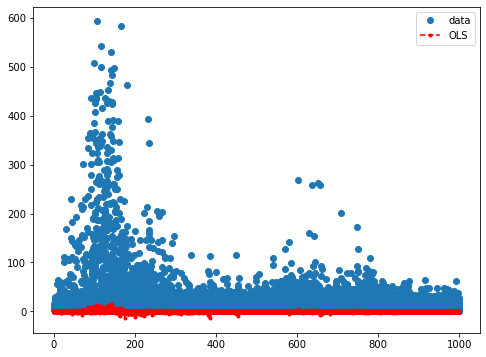

In [50]:
x = np.linspace(0,1000,len(Y))
y_fitted = result_ols.fittedvalues
res = Y - y_fitted
res = (res-res.mean())/res.std()
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, Y, 'o', label='data')
ax.plot(x, res, 'r--.',label='OLS')
ax.legend(loc='best')

In [51]:
bidsIndex = bidsIndex_0
bidsIndex = bidsIndex.drop(['AMOUNT'])
bidsIndex

Index(['INCOME', 'AGE', 'IND_制造业', 'CAR', 'loanId', 'WORKTIME', 'CREDIT',
       'MARRY_已婚', 'PURPOSE_其他借款', 'INTEREST'],
      dtype='object')

In [52]:
X = data_2[bidsIndex]
Y = data_2["BIDS"]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result_ols = model.fit()
result_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BIDS   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     245.2
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        20:32:05   Log-Likelihood:                -50310.
No. Observations:               10000   AIC:                         1.006e+05
Df Residuals:                    9989   BIC:                         1.007e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -67.3928      3.279    -20.552      0.000     -73.821     -60.965
INCOME           8.7481      0.305     28.667      0.000       8.150       9.346
AGE              0.7695      0.067     11.418      0.000       0.637       0.902
IND_制造业         14.3086      0.937     15.273      0.000      12.472      16.145
CAR              3.1661      0.847      3.738      0.000       1.506       4.826
loanId       -3.323e-06   9.11e-07     -3.646      0.000   -5.11e-06   -1.54e-06
WORKTIME         2.2428      0.420      5.336      0.000       1.419       3.067
CREDIT           1.4875      0.257      5.788      0.000       0.984       1.991
MARRY_已婚        -1.8969      0.867     -2.188      0.029      -3.596      -0.197
PURPOSE_其他借款    14.3378      1.771      8.096      0.000      10.866      17.809
INTEREST         1.2182      0.173      7.032      0.000       0.879       1.558
==============================================================================
Omnibus:                    11478.210   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1254822.334
Skew:                           6.011   Prob(JB):                         0.00
Kurtosis:                      56.545   Cond. No.                     5.43e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.43e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
bidsIndex = bidsIndex_0
bidsIndex = bidsIndex.drop(['AMOUNT',"loanId"])
bidsIndex

Index(['INCOME', 'AGE', 'IND_制造业', 'CAR', 'WORKTIME', 'CREDIT', 'MARRY_已婚',
       'PURPOSE_其他借款', 'INTEREST'],
      dtype='object')

In [54]:
X = data_2[bidsIndex]
Y = data_2["BIDS"]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result_ols = model.fit()
result_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BIDS   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     270.6
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        20:32:05   Log-Likelihood:                -50317.
No. Observations:               10000   AIC:                         1.007e+05
Df Residuals:                    9990   BIC:                         1.007e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -72.8437      2.920    -24.945      0.000     -78.568     -67.120
INCOME           8.8799      0.303     29.288      0.000       8.286       9.474
AGE              0.7974      0.067     11.902      0.000       0.666       0.929
IND_制造业         14.3857      0.937     15.350      0.000      12.549      16.223
CAR              3.2746      0.847      3.866      0.000       1.614       4.935
WORKTIME         2.1242      0.419      5.066      0.000       1.302       2.946
CREDIT           1.6431      0.254      6.479      0.000       1.146       2.140
MARRY_已婚        -1.8746      0.867     -2.161      0.031      -3.575      -0.174
PURPOSE_其他借款    14.7318      1.769      8.329      0.000      11.265      18.199
INTEREST         1.4109      0.165      8.547      0.000       1.087       1.735
==============================================================================
Omnibus:                    11478.053   Durbin-Watson:                   1.775
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1253172.136
Skew:                           6.012   Prob(JB):                         0.00
Kurtosis:                      56.507   Cond. No.                         300.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
bidsIndex = bidsIndex_0
bidsIndex = bidsIndex.drop(['AMOUNT',"loanId","MARRY_已婚"])
bidsIndex

Index(['INCOME', 'AGE', 'IND_制造业', 'CAR', 'WORKTIME', 'CREDIT', 'PURPOSE_其他借款',
       'INTEREST'],
      dtype='object')

In [56]:
X = data_2[bidsIndex]
Y = data_2["BIDS"]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result_ols = model.fit()
result_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BIDS   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     303.7
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        20:32:05   Log-Likelihood:                -50319.
No. Observations:               10000   AIC:                         1.007e+05
Df Residuals:                    9991   BIC:                         1.007e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -72.1526      2.903    -24.853      0.000     -77.844     -66.462
INCOME           8.8659      0.303     29.243      0.000       8.272       9.460
AGE              0.7574      0.064     11.761      0.000       0.631       0.884
IND_制造业         14.3604      0.937     15.321      0.000      12.523      16.198
CAR              2.9475      0.834      3.536      0.000       1.314       4.581
WORKTIME         2.0321      0.417      4.871      0.000       1.214       2.850
CREDIT           1.6029      0.253      6.336      0.000       1.107       2.099
PURPOSE_其他借款    14.7556      1.769      8.341      0.000      11.288      18.223
INTEREST         1.4143      0.165      8.566      0.000       1.091       1.738
==============================================================================
Omnibus:                    11480.291   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1253186.560
Skew:                           6.014   Prob(JB):                         0.00
Kurtosis:                      56.507   Cond. No.                         298.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

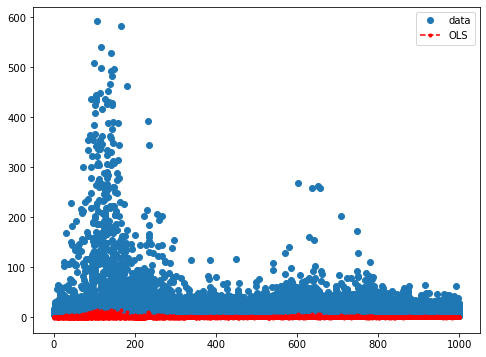

In [57]:
x = np.linspace(0,1000,len(Y))
y_fitted = result_ols.fittedvalues
res = Y - y_fitted
res = (res-res.mean())/res.std()
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, Y, 'o', label='data')
ax.plot(x, res, 'r--.',label='OLS')
ax.legend(loc='best')

In [58]:
bidsIndex = bidsIndex_0
bidsIndex = bidsIndex.drop(['AMOUNT',"loanId","MARRY_已婚","INTEREST"])
bidsIndex

Index(['INCOME', 'AGE', 'IND_制造业', 'CAR', 'WORKTIME', 'CREDIT',
       'PURPOSE_其他借款'],
      dtype='object')

In [59]:
X = data_2[bidsIndex]
Y = data_2["BIDS"]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result_ols = model.fit()
result_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BIDS   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     334.2
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        20:32:06   Log-Likelihood:                -50356.
No. Observations:               10000   AIC:                         1.007e+05
Df Residuals:                    9992   BIC:                         1.008e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -55.6554      2.180    -25.527      0.000     -59.929     -51.382
INCOME           8.8782      0.304     29.178      0.000       8.282       9.475
AGE              0.8132      0.064     12.647      0.000       0.687       0.939
IND_制造业         14.8213      0.939     15.782      0.000      12.980      16.662
CAR              2.6880      0.836      3.215      0.001       1.049       4.327
WORKTIME         1.9524      0.419      4.664      0.000       1.132       2.773
CREDIT           1.4124      0.253      5.585      0.000       0.917       1.908
PURPOSE_其他借款    14.8417      1.775      8.360      0.000      11.362      18.322
==============================================================================
Omnibus:                    11562.235   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1281987.443
Skew:                           6.087   Prob(JB):                         0.00
Kurtosis:                      57.116   Cond. No.                         211.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

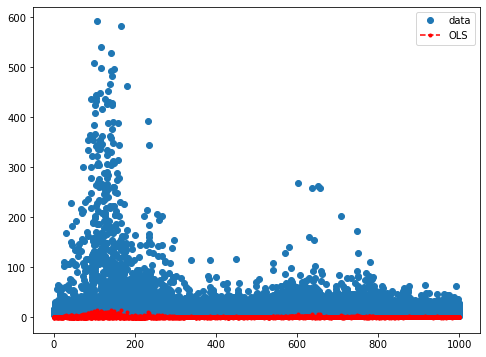

In [60]:
x = np.linspace(0,1000,len(Y))
y_fitted = result_ols.fittedvalues
res = Y - y_fitted
res = (res-res.mean())/res.std()
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, Y, 'o', label='data')
ax.plot(x, res, 'r--.',label='OLS')
ax.legend(loc='best')

<a id="2"></a>
## 2.P2P Lending Platform

<a id="2.1"></a>
## 2.1 P2P Lending Platform Data Summary

In [61]:
data_p2p = pd.read_csv(r"..\Week 2 Assignment\p2p.csv",encoding="gbk")
data_p2p.head()

,fullname,OnlineTime_YMD,Bankrupt_WDZJ,Province,City,Collapse,Benign,Fraud,RegCapital,Background,Capitaldeposit,Obtaininvest,Joinasso,Autobid,Transright,Riskdeposit,Thirdguarantee
0,123便利贷,20140519,20170413.0,上海,上海,1,0.0,0.0,500.0,民营系,0,0.0,1.0,0,0,0.0,0.0
1,17聚财,20151231,20170201.0,上海,上海,1,0.0,0.0,500.0,民营系,0,0.0,0.0,0,0,0.0,0.0
2,360易贷,20150504,20161201.0,辽宁,沈阳,1,0.0,0.0,500.0,民营系,0,0.0,0.0,1,1,0.0,0.0
3,365储蓄家,20180310,20180615.0,浙江,杭州,1,0.0,0.0,500.0,民营系,0,0.0,0.0,0,0,0.0,0.0
4,51丰收宝,20180320,20180724.0,广东,深圳,1,0.0,1.0,5.0,民营系,0,0.0,0.0,0,0,0.0,0.0


In [62]:
data_p2p.shape

(1000, 17)

In [63]:
data_p2p.describe()

,OnlineTime_YMD,Bankrupt_WDZJ,Collapse,Benign,Fraud,RegCapital,Capitaldeposit,Obtaininvest,Joinasso,Autobid,Transright,Riskdeposit,Thirdguarantee
count,1.000000e+03,7.820000e+02,1000.000000,782.000000,782.000000,1000.000000,1000.000000,968.000000,968.000000,1000.000000,1000.00000,968.000000,968.000000
mean,2.014850e+07,2.016330e+07,0.782000,0.098465,0.246803,596.064330,0.191000,0.026860,0.054752,0.244000,0.17700,0.021694,0.034091
std,1.135194e+04,1.304322e+04,0.413094,0.298134,0.431427,2328.221711,0.393286,0.161756,0.227613,0.429708,0.38186,0.145758,0.181557
min,2.009041e+07,2.012060e+07,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,2.014092e+07,2.015112e+07,1.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2.015040e+07,2.016080e+07,1.000000,0.000000,0.000000,300.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,2.015112e+07,2.017111e+07,1.000000,0.000000,0.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,2.018052e+07,2.019090e+07,1.000000,1.000000,1.000000,50000.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


#### Generate Duration feature baed on OnlineTime and bankrupt time

In [64]:
data_p2p["endtime"] = data_p2p["Bankrupt_WDZJ"]
data_p2p["endtime"][data_p2p["endtime"].isnull()] = 20210000
data_p2p["Duration"] = data_p2p["endtime"] - data_p2p["OnlineTime_YMD"]
data_p2p.describe()["Duration"]

<ipython-input-64-d566a584de42>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_p2p["endtime"][data_p2p["endtime"].isnull()] = 20210000


count      1000.000000
mean      24984.026000
std       22517.608339
min           0.000000
25%        9604.750000
50%       19517.500000
75%       39737.250000
max      108987.000000
Name: Duration, dtype: float64

#### Generate Dummy variabel for Background

In [65]:
data_p2p = pd.get_dummies(data_p2p,columns=["Background"])

#### Correlationship test

In [66]:
abs(data_p2p.corr()["Collapse"]).sort_values(ascending=False)
collapse_index_0 = abs(data_p2p.corr()["Collapse"]).sort_values(ascending=False).index[3:16]
collapse_index_0


Collapse           1.000000
endtime            0.858307
Duration           0.821433
Capitaldeposit     0.476656
Joinasso           0.231163
Background_民营系     0.214158
Transright         0.173962
Background_上市公司    0.164302
Background_国企背景    0.138415
Obtaininvest       0.092409
Autobid            0.077865
Thirdguarantee     0.076601
OnlineTime_YMD     0.069903
Background_风投系     0.060771
Riskdeposit        0.031732
RegCapital         0.028437
Bankrupt_WDZJ           NaN
Benign                  NaN
Fraud                   NaN
Name: Collapse, dtype: float64

Index(['Capitaldeposit', 'Joinasso', 'Background_民营系', 'Transright',
       'Background_上市公司', 'Background_国企背景', 'Obtaininvest', 'Autobid',
       'Thirdguarantee', 'OnlineTime_YMD', 'Background_风投系', 'Riskdeposit',
       'RegCapital'],
      dtype='object')

<AxesSubplot:>

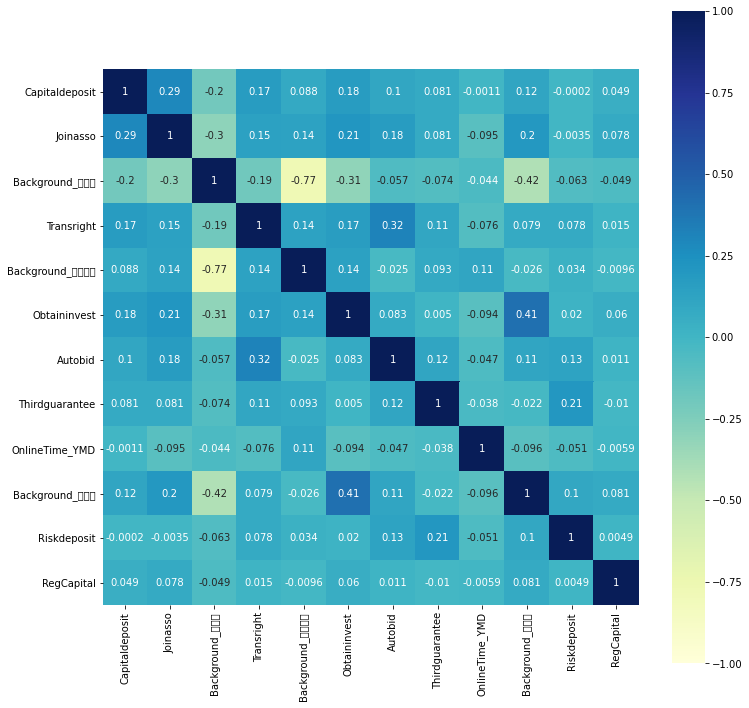

In [79]:
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(data_p2p[collapse_index_0].corr(),annot=True, vmax=1, vmin=-1,square=True,cmap="YlGnBu")

In [68]:
collapse_index_0 = collapse_index_0.drop("Background_上市公司")
collapse_index_0

Index(['Capitaldeposit', 'Joinasso', 'Background_民营系', 'Transright',
       'Background_国企背景', 'Obtaininvest', 'Autobid', 'Thirdguarantee',
       'OnlineTime_YMD', 'Background_风投系', 'Riskdeposit', 'RegCapital'],
      dtype='object')

In [69]:
data_p2p.describe()[collapse_index_0]

,Capitaldeposit,Joinasso,Background_民营系,Transright,Background_国企背景,Obtaininvest,Autobid,Thirdguarantee,OnlineTime_YMD,Background_风投系,Riskdeposit,RegCapital
count,1000.000000,968.000000,1000.000000,1000.00000,1000.00000,968.000000,1000.000000,968.000000,1.000000e+03,1000.000000,968.000000,1000.000000
mean,0.191000,0.054752,0.924000,0.17700,0.04600,0.026860,0.244000,0.034091,2.014850e+07,0.014000,0.021694,596.064330
std,0.393286,0.227613,0.265131,0.38186,0.20959,0.161756,0.429708,0.181557,1.135194e+04,0.117549,0.145758,2328.221711
min,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,2.009041e+07,0.000000,0.000000,2.000000
25%,0.000000,0.000000,1.000000,0.00000,0.00000,0.000000,0.000000,0.000000,2.014092e+07,0.000000,0.000000,100.000000
50%,0.000000,0.000000,1.000000,0.00000,0.00000,0.000000,0.000000,0.000000,2.015040e+07,0.000000,0.000000,300.000000
75%,0.000000,0.000000,1.000000,0.00000,0.00000,0.000000,0.000000,0.000000,2.015112e+07,0.000000,0.000000,500.000000
max,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,2.018052e+07,1.000000,1.000000,50000.000000


### Fill numm value with median

In [77]:
for index in collapse_index_0:
    data_p2p[index][data_p2p[index].isnull()] = data_p2p[index].median()
data_p2p.describe()[collapse_index_0]

<ipython-input-77-6be0ba80bab6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_p2p[index][data_p2p[index].isnull()] = data_p2p[index].median()
<ipython-input-77-6be0ba80bab6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_p2p[index][data_p2p[index].isnull()] = data_p2p[index].median()
<ipython-input-77-6be0ba80bab6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_p2p[index][data_p2p[index].isnull()] = data_p2p[index

,Capitaldeposit,Joinasso,Background_民营系,Transright,Background_国企背景,Obtaininvest,Autobid,Thirdguarantee,OnlineTime_YMD,Background_风投系,Riskdeposit,RegCapital
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,0.191000,0.053000,0.924000,0.17700,0.04600,0.026000,0.244000,0.033000,2.014850e+07,0.014000,0.021000,596.064330
std,0.393286,0.224146,0.265131,0.38186,0.20959,0.159215,0.429708,0.178726,1.135194e+04,0.117549,0.143456,2328.221711
min,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,2.009041e+07,0.000000,0.000000,2.000000
25%,0.000000,0.000000,1.000000,0.00000,0.00000,0.000000,0.000000,0.000000,2.014092e+07,0.000000,0.000000,100.000000
50%,0.000000,0.000000,1.000000,0.00000,0.00000,0.000000,0.000000,0.000000,2.015040e+07,0.000000,0.000000,300.000000
75%,0.000000,0.000000,1.000000,0.00000,0.00000,0.000000,0.000000,0.000000,2.015112e+07,0.000000,0.000000,500.000000
max,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,2.018052e+07,1.000000,1.000000,50000.000000


<a id="2.2"></a>
## 2.2 Cox model
features are significant(p<=0.5): Joinasso, Background_民营, Transright,Autobid  
    (1) When a commpany has joined the associate, it is 0.63 times to collapse  
    (2) When a company is private it is 3.08 times more likely to collapse  
    (3) If a company provides bonds transfering, it is 0.62 times as same as those not to collapse  
    (4) If a firm provides auto-bid it is 0.83 times as same as those not to collapse  

In [71]:
from lifelines import CoxPHFitter

In [72]:
collapse_index_0

Index(['Capitaldeposit', 'Joinasso', 'Background_民营系', 'Transright',
       'Background_国企背景', 'Obtaininvest', 'Autobid', 'Thirdguarantee',
       'OnlineTime_YMD', 'Background_风投系', 'Riskdeposit', 'RegCapital'],
      dtype='object')

In [73]:
data_cox = data_p2p[['Capitaldeposit', 'Joinasso', 'Background_民营系', 'Transright',
       'Background_国企背景', 'Obtaininvest', 'Autobid', 'Thirdguarantee',
        'Background_风投系', 'Riskdeposit', 'RegCapital',"Duration","Collapse"]]

In [74]:
cph = CoxPHFitter()
cph.fit(data_cox, 'Duration', event_col='Collapse')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1000 total observations, 218 right-censored observations>

<lifelines.CoxPHFitter: fitted with 1000 total observations, 218 right-censored observations>
             duration col = 'Duration'
                event col = 'Collapse'
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 782
   partial log-likelihood = -4770.93
         time fit was run = 2021-09-24 12:32:08 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
Capitaldeposit   -1.51       0.22       0.13            -1.76            -1.26                 0.17                 0.28
Joinasso         -0.46       0.63       0.23            -0.91            -0.01                 0.40                 0.99
Background_民营系    1.12       3.08       0.51             0.13             2.12                 1.14                 8.32
Transright       -0.47       0.62       0.11            -0.68            -0.26                 0.50                 0.77
Background_国企背景   0.59       1.80       0.54            -0.48             1.65                 0.62                 5.21
Obtaininvest      0.08       1.09       0.28            -0.47             0.64                 0.62                 1.90
Autobid          -0.19       0.83       0.09            -0.37            -0.01                 0.69                 0.99
Thirdguarantee   -0.17       0.85       0.23            -0.61             0.28                 0.54                 1.32
Background_风投系    0.80       2.23       0.62            -0.41             2.02                 0.66                 7.53
Riskdeposit      -0.10       0.90       0.27            -0.63             0.42                 0.53                 1.52
RegCapital        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                     z      p   -log2(p)
covariate                               
Capitaldeposit  -11.77 <0.005     103.82
Joinasso         -2.00   0.05       4.45
Background_民营系    2.22   0.03       5.23
Transright       -4.38 <0.005      16.39
Background_国企背景   1.08   0.28       1.83
Obtaininvest      0.29   0.77       0.38
Autobid          -2.09   0.04       4.79
Thirdguarantee   -0.74   0.46       1.12
Background_风投系    1.29   0.20       2.35
Riskdeposit      -0.39   0.70       0.52
RegCapital        0.31   0.75       0.41
---
Concordance = 0.68
Partial AIC = 9563.85
log-likelihood ratio test = 327.07 on 11 df
-log2(p) of ll-ratio test = 208.51

<AxesSubplot:xlabel='log(HR) (95% CI)'>

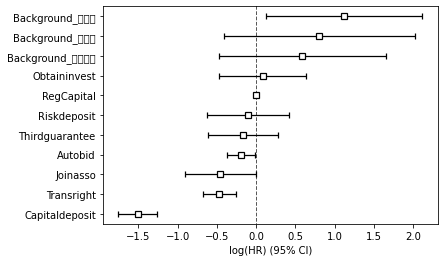

In [76]:
cph.plot()